In [23]:
#Import the libraries
import os,random
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa as lib
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import wavfile as wav
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import IPython.display as ipd
%matplotlib inline

In [24]:
#Access the audio image filepath
train_audio_path = '../Dataset audio samples/classification dataset/'
test_audio_path = '../Dataset audio samples/classification test samples/'
labels = os.listdir(train_audio_path)
print(labels)

['left', 'one', 'right', 'stop', 'three', 'two']


In [6]:
#Audio signal EDA and visualization
test_sample, test_rate = lib.load(train_audio_path+'right/0ea0e2f4_nohash_0.wav', sr=8000)

print(test_sample.shape)
print(test_rate)
print(len(test_sample))
print(len(test_sample)/test_rate)

(8000,)
8000
8000
1.0


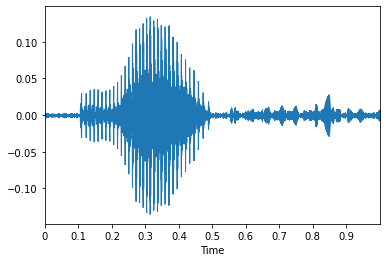

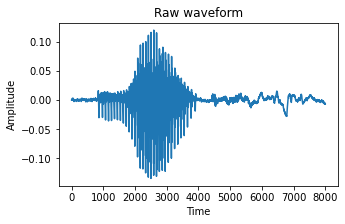

In [7]:
#Plotting the time-series amplitude-time waveform
librosa.display.waveplot(test_sample, test_rate)

#Plotting using matplotlib
plt.figure(figsize=(5,3))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Raw waveform')
plt.plot(test_sample)

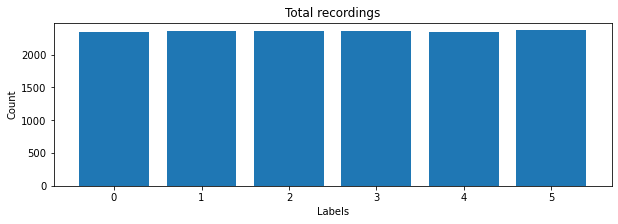

In [8]:
#No. of recordings in each label
sample_count=[]

for label in labels:
    sample_count.append(len([f for f in os.listdir(train_audio_path+label) if f.endswith('.wav')]))

#Plotting using matplotlib
plt.figure(figsize=(10,3))
index = np.arange(len(labels))
plt.bar(index, sample_count)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Total recordings')
plt.show(sample_count)

C:\Users\Mehak\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Mehak\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


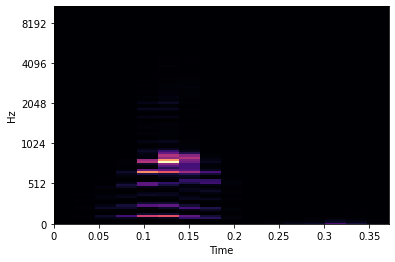

In [10]:
#Display spectogram
ipd.Audio(train_audio_path+'right/0ea0e2f4_nohash_0.wav')
spec = lib.feature.melspectrogram(test_sample,test_rate)
lib.display.specshow(spec, y_axis='mel', x_axis='time')

Scipy: sample, rate, bit-depth(min, max):  [  -9   -4   -8 ... -209 -197 -183] 16000 -4410 3930
Librosa: sample, rate, bit-depth(min, max):  [-0.00026596 -0.00018007 -0.000125   ... -0.00602599 -0.00643429
 -0.00410269] 22050 -0.13435018 0.12273543


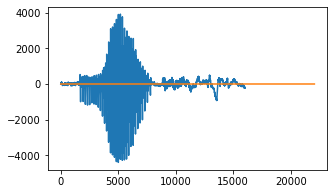

In [12]:
#Audio signal preprocessing
# 1. Resampling
# 2. Signal duration filtering (<1s)
# 3. Bit rate depth normalization
# 4. Stereo to mono channel
#
# Librosa libarary handles resampling (22.5kHz, sterso to mono channel, bit-depth normalization)
audio_file = train_audio_path+'right/0ea0e2f4_nohash_0.wav'
scipy_rate, scipy_audio= wav.read(audio_file)
lib_audio, lib_rate = lib.load(audio_file)


print('Scipy: sample, rate, bit-depth(min, max): ', scipy_audio, scipy_rate, np.min(scipy_audio), np.max(scipy_audio))
print('Librosa: sample, rate, bit-depth(min, max): ', lib_audio, lib_rate, np.min(lib_audio), np.max(lib_audio))

plt.figure(figsize=(5,3))
plt.plot(scipy_audio)
plt.plot(lib_audio)

In [13]:
#Preprocessing below:
#Resampling at 8000kHz
#Filtering out audio <1s in length
#Creating arrays of audio and its labels an dcreate a dataframe from them

x_audio_array=[]
y_label_array=[]
sample_rate = 8000
count = 0
count1 = 0

for label in labels:
    audios = [f for f in os.listdir(train_audio_path+label) if f.endswith('.wav')]
    for aud in audios:
        count+=1
        #Resampling
        sam,rate = lib.load(train_audio_path+label+'/'+aud, sr=sample_rate)
        if len(sam)/rate == 1:
            count1+=1
            #Feature extraction using MFCC
            mfcc = lib.feature.mfcc(sam, sr = sample_rate, n_mfcc=40)
            x_audio_array.append(mfcc)
            y_label_array.append(label)

In [14]:
#Create pandas dataframe
x_audio_array = np.array(x_audio_array)
y_label_array = np.array(y_label_array)
df=pd.DataFrame(list(zip(np.array(x_audio_array), y_label_array)), columns =['Audio', 'Label'])
df.head()

#Shuffle the dataset
df = df.sample(frac=1)

In [15]:
df.head()
print(x_audio_array.shape)
print(y_label_array.shape)

(12837, 40, 16)
(12837,)


In [16]:
#Encoding categorical data(labels)
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y_label_array)
print(y_encoded.shape)

(12837, 6)


In [17]:
x_audios = np.array(x_audio_array).reshape(x_audio_array.shape[0], 40, 16)
print(x_audios.shape)

(12837, 40, 16)


In [18]:
#Split datasets into training and test data
x_train, x_test, y_train, y_test = train_test_split(x_audios, y_encoded, test_size=0.3, random_state=0)

print(x_train.shape)

(8985, 40, 16)


In [19]:
#Create RNN model

#Initializing the RNN
rnn = Sequential()

#Add 1st LSTM and dropout regularization layer
rnn.add(LSTM(units=80, return_sequences=True, input_shape=[40,16]))
rnn.add(Dropout(0.3))

#Add 2nd LSTM and dropout regularization layer
rnn.add(LSTM(units=80,return_sequences = True))
rnn.add(Dropout(0.3))

#Add 3rd LSTM and dropout regularization layer
rnn.add(LSTM(units=80,return_sequences = True))
rnn.add(Dropout(0.3))

#Add 4th LSTM and dropout regularization layer
rnn.add(LSTM(units=80))
rnn.add(Dropout(0.3))

#Add the fully connected output layer
rnn.add(Dense(units=6, activation='softmax'))

rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 80)            31040     
_________________________________________________________________
dropout (Dropout)            (None, 40, 80)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 80)            51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 80)            51520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                5

In [20]:
#Compile CNN
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Fit the model(train)
rnn.fit(x_train, y_train, batch_size=32, epochs=150)

Epoch 1/150
281/281 [==============================] - 55s 197ms/step - loss: 1.6596 - accuracy: 0.2871
Epoch 2/150
281/281 [==============================] - 67s 240ms/step - loss: 1.4307 - accuracy: 0.4002
Epoch 3/150
281/281 [==============================] - 67s 238ms/step - loss: 1.2843 - accuracy: 0.4622
Epoch 4/150
281/281 [==============================] - 70s 248ms/step - loss: 1.1574 - accuracy: 0.5330
Epoch 5/150
281/281 [==============================] - 71s 251ms/step - loss: 1.0720 - accuracy: 0.5721
Epoch 6/150
281/281 [==============================] - 74s 263ms/step - loss: 0.9736 - accuracy: 0.6144
Epoch 7/150
281/281 [==============================] - 75s 268ms/step - loss: 0.9211 - accuracy: 0.6484
Epoch 8/150
281/281 [==============================] - 76s 270ms/step - loss: 0.8537 - accuracy: 0.6693
Epoch 9/150
281/281 [==============================] - 75s 266ms/step - loss: 0.7902 - accuracy: 0.7014
Epoch 10/150
281/281 [==============================] - 74s 262m

281/281 [==============================] - 65s 232ms/step - loss: 0.1096 - accuracy: 0.9633s - loss: 0.1096 - accuracy: 0.96
Epoch 79/150
281/281 [==============================] - 65s 232ms/step - loss: 0.0937 - accuracy: 0.9703
Epoch 80/150
281/281 [==============================] - 65s 233ms/step - loss: 0.1090 - accuracy: 0.9628
Epoch 81/150
281/281 [==============================] - 65s 230ms/step - loss: 0.1016 - accuracy: 0.9653
Epoch 82/150
281/281 [==============================] - 60s 214ms/step - loss: 0.1063 - accuracy: 0.9648
Epoch 83/150
281/281 [==============================] - 59s 211ms/step - loss: 0.0933 - accuracy: 0.9698
Epoch 84/150
281/281 [==============================] - 57s 204ms/step - loss: 0.1038 - accuracy: 0.9645
Epoch 85/150
281/281 [==============================] - 58s 206ms/step - loss: 0.0974 - accuracy: 0.9667
Epoch 86/150
281/281 [==============================] - 57s 202ms/step - loss: 0.1050 - accuracy: 0.9659
Epoch 87/150
281/281 [=============

In [41]:
# Evaluating the model on the training and testing set
score = rnn.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = rnn.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9976627826690674
Testing Accuracy:  0.8406022787094116


In [42]:
#Predict using ann model
res=rnn.predict(x_test)
print(lb.inverse_transform((res[0].reshape(1,-1)))[0])
print('Accuracy score: ', accuracy_score(lb.inverse_transform(y_test),lb.inverse_transform(res)))

stop
Accuracy score:  0.8406022845275182


In [44]:
import sounddevice as sd
from scipy.io.wavfile import write

def record_audio():
    rate = 8000  # Sample rate
    seconds = 1  # Duration of recording

    my_audio = sd.rec(int(seconds * rate), samplerate=rate, channels=1)
    sd.wait()  # Wait until recording is finished
    write(test_audio_path + 'test.wav', rate, my_audio)  # Save as WAV file 
    return 'test.wav'
    
def predict_audio(filename):
    filepath = test_audio_path + filename
    audio, sam = lib.load(filepath, sr=8000)
    mfcc = lib.feature.mfcc(audio, sr = sample_rate, n_mfcc = 40)
    pad_width = 16 - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
    audio_predicted=rnn.predict(mfcc.reshape(1,40,16))
    audio_class = lb.inverse_transform(audio_predicted)
    print('Your audio (' + filename + ') belongs to the label: ', audio_class[0].upper())

In [46]:
#Classify a random audio file from the unlabeled test folder
file = random.choice([f for f in os.listdir(test_audio_path)])
predict_audio(file)
ipd.Audio(test_audio_path+file, autoplay=True)

Your audio (two2.wav) belongs to the label:  TWO


In [48]:
#Classify a live spoken audio through microphone
predict_audio(record_audio())
ipd.Audio(test_audio_path+'test.wav', autoplay=True)

Your audio (test.wav) belongs to the label:  LEFT
